In [ ]:
!PYTHONHASHSEED=1234

In [ ]:
import os
import math
import json
import pickle
import tempfile
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
import matplotlib.pyplot as plt
import random as python_random
from sklearn.metrics import classification_report, confusion_matrix

## Data loading

Mounted at /content/gdrive


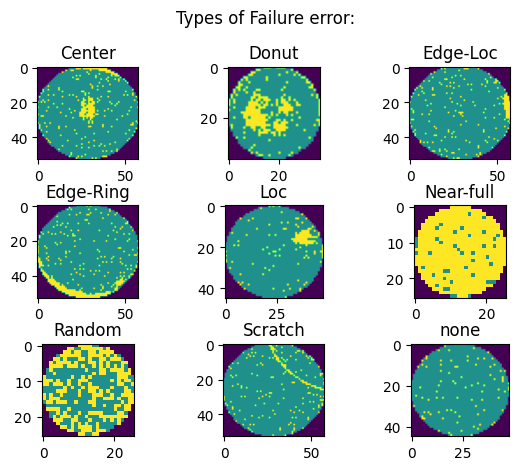

In [ ]:
python_random.seed(1234)
tf.random.set_seed(1234)
drive.mount('/content/gdrive')
if os.path.exists('gdrive/My Drive/dataset.pkl'):
    df = pd.read_pickle('gdrive/My Drive/dataset.pkl')
    uniqueType = df['failureType'].unique()
    uniqueType.sort()

    plt.suptitle('Types of Failure error:\n', y=1)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    for i in range(len(uniqueType)):
        plt.subplot(math.ceil(len(uniqueType) / 3), min(len(uniqueType), 3), i+1)
        plt.imshow(df.iloc[df[df['failureType'] == uniqueType[i]].index[0]]['waferMap'])
        plt.title(uniqueType[i])
else:
    df=pd.read_pickle("gdrive/My Drive/WM811K.pkl")
    df = df[(df['trainTestLabel'] == 'Training') | (df['trainTestLabel'] == 'Test')]

    uniqueType = df['failureType'].unique()
    uniqueType.sort()

    plt.suptitle('Types of Failure error:\n', y=1)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    for i in range(len(uniqueType)):
        plt.subplot(math.ceil(len(uniqueType) / 3), min(len(uniqueType), 3), i+1)
        plt.imshow(df.iloc[df[df['failureType'] == uniqueType[i]].index[0]]['waferMap'], extent = [0,40,0,40])
        plt.title(uniqueType[i])

    df = df.drop(['dieSize','lotName','waferIndex','trainTestLabel'], axis = 1)
    df = df.reset_index(drop=True)

    with open('gdrive/My Drive/dataset.pkl', 'wb') as f:
        pickle.dump(df, f)

In [ ]:
df

,failureType,waferMap
0,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...
172945,Edge-Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,..."
172946,Edge-Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,..."
172947,Edge-Ring,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,..."
172948,Edge-Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,..."


<BarContainer object of 9 artists>

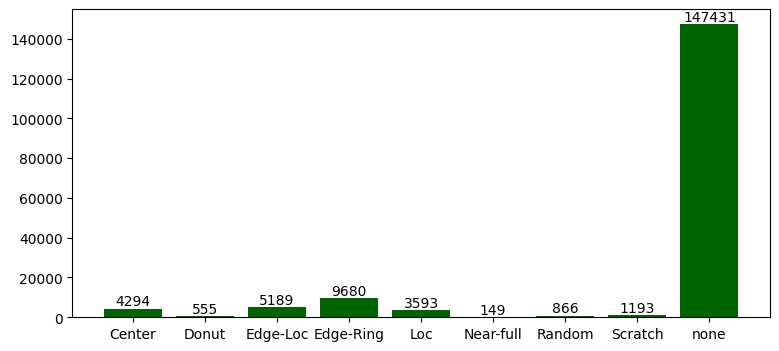

In [ ]:
t = df['failureType']
l = []
for a in uniqueType:
    l.append(len(t[t==a]))
plt.figure(figsize=(9,4))
for i, v in enumerate(l):
    plt.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10)
plt.bar(uniqueType,l, color = 'darkgreen')

## Preprocessing

<BarContainer object of 9 artists>

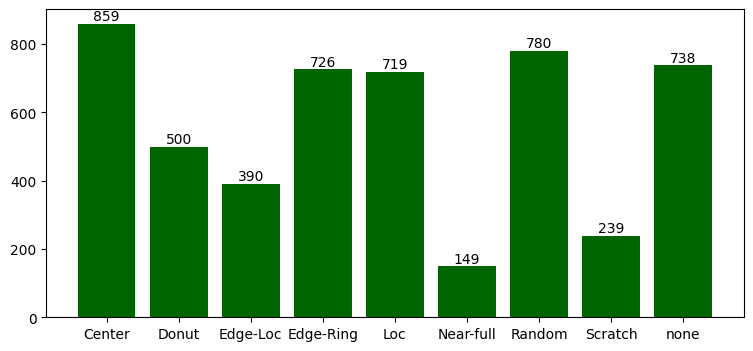

In [ ]:
data = pd.DataFrame()

for failureType in uniqueType:
    new_data = df[df['failureType'] == failureType]

    if len(new_data) <= 500:
        sampleSize = len(new_data)
    elif len(new_data) <= 1000:
        sampleSize = math.ceil(0.9 * len(new_data))
    elif len(new_data) <= 5000:
        sampleSize = math.ceil(0.2 * len(new_data))
    elif len(new_data) <= 10000:
        sampleSize = math.ceil(0.075 * len(new_data))
    else:
        sampleSize = math.ceil(0.005 * len(new_data))

    trainSample = new_data[:sampleSize]

    data = pd.concat([data, trainSample])

# t = data['failureType']
# for a in uniqueType:
#     print(f'{a}: {len(t[t == a])}')
# print(f'{len(data)}')


t = data['failureType']
l = []
for a in uniqueType:
    l.append(len(t[t==a]))
plt.figure(figsize=(9,4))
for i, v in enumerate(l):
    plt.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10)
plt.bar(uniqueType,l, color = 'darkgreen')

## Data loader: Training set and Test set

In [ ]:
if os.path.exists('/content/gdrive/MyDrive/imagesProject'):
    train_dataset = keras.preprocessing.image_dataset_from_directory("/content/gdrive/MyDrive/imagesProject/",
                                                                    image_size=(224, 224),
                                                                    batch_size=32,
                                                                    label_mode='categorical',
                                                                    subset='training',
                                                                    validation_split=0.2,
                                                                    shuffle=True,
                                                                    seed=1)
    test_dataset = keras.preprocessing.image_dataset_from_directory('/content/gdrive/MyDrive/imagesProject/',
                                                                    image_size=(224, 224),
                                                                    batch_size=32,
                                                                    label_mode='categorical',
                                                                    subset='validation',
                                                                    validation_split=0.2,
                                                                    shuffle=True,
                                                                    seed=1)
else:
    os.path.join('/content/gdrive/MyDrive', 'imagesProject')

    for label in uniqueType:
        os.makedirs(os.path.join("/content/gdrive/MyDrive/imagesProject", label))

    # Save image data as separate image files in class-specific subdirectories
    for i in range(len(data)):
        f = data.index
        at = data['failureType']
        aw = data['waferMap']
        image = plt.imshow(aw[f[i]], extent=[0, 40, 0, 40])
        image_path = os.path.join(f'/content/gdrive/MyDrive/imagesProject/{at[f[i]]}', f'{at[f[i]]}_{f[i]}.png')
        plt.savefig(image_path, bbox_inches='tight', pad_inches=0)
        plt.close()

    # # Create the image dataset
    train_dataset = keras.preprocessing.image_dataset_from_directory('/content/gdrive/MyDrive/imagesProject/',
                                                                    image_size=(224, 224),
                                                                    batch_size=32,
                                                                    label_mode='categorical',
                                                                    subset='training',
                                                                    validation_split=0.2,
                                                                    shuffle=True,
                                                                    seed=1)
    test_dataset = keras.preprocessing.image_dataset_from_directory('/content/gdrive/MyDrive/imagesProject/',
                                                                    image_size=(224, 224),
                                                                    batch_size=32,
                                                                    label_mode='categorical',
                                                                    subset='validation',
                                                                    validation_split=0.2,
                                                                    shuffle=True,
                                                                    seed=1)

Found 5100 files belonging to 9 classes.
Using 4080 files for training.
Found 5100 files belonging to 9 classes.
Using 1020 files for validation.


In [ ]:
# Settings for prettier visualization in Google Colab
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

In [ ]:
# Retrieving the ground truth classes
yc_test = np.concatenate([y for _, y in test_dataset], axis=0)
y_test = np.argmax(yc_test, axis=1)

<IPython.core.display.Javascript object>

## Model 1

In [ ]:
# Define the folder name and the file name
file_name = 'history1.pkl'

# Define the full folder path
folder_path = os.path.join('/content/gdrive/MyDrive', 'History')

# Define the full file path
file_path = os.path.join(folder_path, file_name)

# Check if the file exists in the specified path
if os.path.exists(file_path):
    model1 = keras.models.load_model('/content/gdrive/MyDrive/History/model1.h5')
    # Load the variables from the existing file
    with open(file_path, 'rb') as f:
        load_history1 = pickle.load(f)
else:
    # Architecture definition v1
    inputs = keras.Input((224, 224, 3))

    x = inputs
    x = keras.layers.Conv2D(32, 2, padding="same", activation="relu")(x)
    x = keras.layers.MaxPooling2D(2)(x)

    x = keras.layers.Conv2D(64, 2, padding="same", activation="relu")(x)
    x = keras.layers.GlobalMaxPooling2D()(x)

    outputs = keras.layers.Dense(9, activation="softmax")(x)
    net = keras.Model(inputs, outputs)

    # Compile the model for training
    net.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
                metrics=['accuracy'])
    # Create a new dictionary to store the variables
    history = net.fit(train_dataset,
                      epochs=40,
                      validation_data=test_dataset);

    net.save('/content/gdrive/MyDrive/History/model1.h5')

    # Check if the folder exists, otherwise create it
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Save the dictionary containing the variables to the specified path
    with open(file_path, 'wb') as f:
        pickle.dump(history, f)

    model1 = keras.models.load_model('/content/gdrive/MyDrive/History/model1.h5')

    # Load the variables from the existing file
    with open(file_path, 'rb') as f:
        load_history1 = pickle.load(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

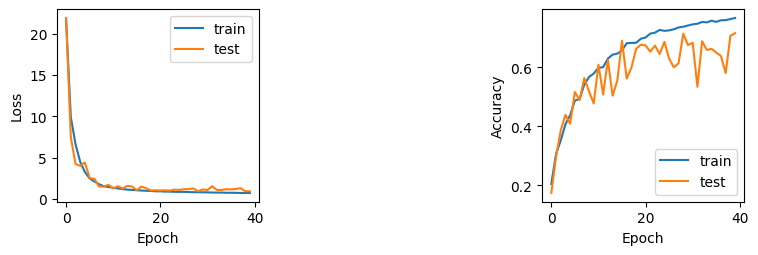

In [ ]:
# Visualization of the learning curves
plt.figure(figsize=(12,2.5))
plt.subplot(1, 4, 1)
plt.plot(load_history1.history['loss'])
plt.plot(load_history1.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

plt.subplot(1, 4, 3)
plt.plot(load_history1.history['accuracy'])
plt.plot(load_history1.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

In [ ]:
score = model1.evaluate(test_dataset)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

<IPython.core.display.Javascript object>

32/32 [==============================] - 27s 771ms/step - loss: 0.9048 - accuracy: 0.7157
Test loss: 0.9048000574111938
Test accuracy: 0.7156862616539001


In [ ]:
# Inference
yc_pred = model1.predict(test_dataset)
print('Prediction shape (probability distribution):', yc_pred.shape)

<IPython.core.display.Javascript object>

32/32 [==============================] - 25s 739ms/step
Prediction shape (probability distribution): (1020, 9)


In [ ]:
# Selection of the highest-probability class for each test sample
y_pred = np.argmax(yc_pred, axis=1)
print('Prediction shape (argmax):', y_pred.shape)

<IPython.core.display.Javascript object>

Prediction shape (argmax): (1020,)


In [ ]:
# Classification report
print('Classification report of model 1:')
print(classification_report(y_test, y_pred))

<IPython.core.display.Javascript object>

Classification report of model 1:
              precision    recall  f1-score   support

           0       0.13      0.18      0.15       175
           1       0.11      0.10      0.11        96
           2       0.00      0.00      0.00        66
           3       0.14      0.13      0.14       154
           4       0.17      0.09      0.11       149
           5       0.04      0.04      0.04        24
           6       0.18      0.18      0.18       150
           7       0.06      0.11      0.08        44
           8       0.15      0.15      0.15       162

    accuracy                           0.13      1020
   macro avg       0.11      0.11      0.11      1020
weighted avg       0.13      0.13      0.13      1020



<IPython.core.display.Javascript object>

Confusion matrix:


Text(0, 0.5, 'Ground truth class')

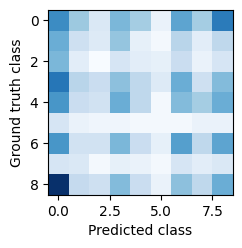

In [ ]:
# Confusion matrix
plt.figure(figsize=(2.4,2.4))
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')

## Model 2

In [ ]:
#New file name
file_name = 'history2.pkl'

# Define the full file path
file_path = os.path.join(folder_path, file_name)

# Check if the file exists in the specified path
if os.path.exists(file_path):
    model2 = keras.models.load_model('/content/gdrive/MyDrive/History/model2.h5')
    # Load the variables from the existing file
    with open(file_path, 'rb') as f:
        load_history2 = pickle.load(f)
else:
    # Architecture definition v2
    inputs = keras.Input((224,224,3))

    x = inputs
    x = keras.layers.Conv2D(32, 2, padding="same", activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(2, strides=3, padding="same")(x)

    x = keras.layers.Conv2D(64, 2, padding="same", activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.GlobalMaxPooling2D()(x)

    outputs = keras.layers.Dense(9, activation="softmax")(x)
    net2 = keras.Model(inputs, outputs)

    # Compile the model for training
    net2.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
                metrics=['accuracy'])

    # Create a new dictionary to store the variables
    history2 = net2.fit(train_dataset,
                        epochs=40,
                        validation_data=test_dataset);
    net2.save('/content/gdrive/MyDrive/History/model2.h5')

    # Check if the folder exists, otherwise create it
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Save the dictionary containing the variables to the specified path
    with open(file_path, 'wb') as f:
        pickle.dump(history2, f)

    model2 = keras.models.load_model('/content/gdrive/MyDrive/History/model2.h5')

    # Load the variables from the existing file
    with open(file_path, 'rb') as f:
        load_history2 = pickle.load(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

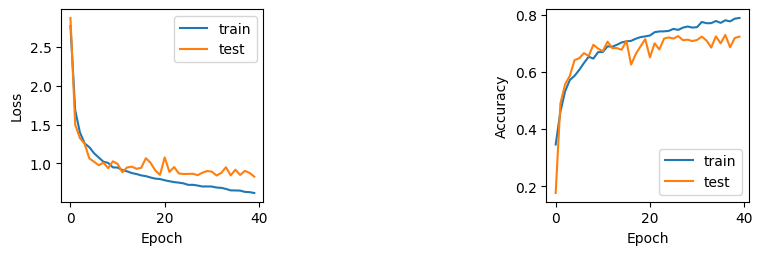

In [ ]:
# Visualization of the learning curves
plt.figure(figsize=(12,2.5))
plt.subplot(1, 4, 1)
plt.plot(load_history2.history['loss'])
plt.plot(load_history2.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

plt.subplot(1, 4, 3)
plt.plot(load_history2.history['accuracy'])
plt.plot(load_history2.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

In [ ]:
# model2 = keras.models.load_model('/content/gdrive/MyDrive/History/model2.h5')

score2 = model2.evaluate(test_dataset)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

<IPython.core.display.Javascript object>

32/32 [==============================] - 27s 771ms/step - loss: 0.8312 - accuracy: 0.7235
Test loss: 0.8312113881111145
Test accuracy: 0.7235293984413147


In [ ]:
# Inference
yc_pred2 = model2.predict(test_dataset)
print('Prediction shape (probability distribution):', yc_pred2.shape)

<IPython.core.display.Javascript object>

32/32 [==============================] - 28s 809ms/step
Prediction shape (probability distribution): (1020, 9)


In [ ]:
# Selection of the highest-probability class for each test sample
y_pred2 = np.argmax(yc_pred2, axis=1)
print('Prediction shape (argmax):', y_pred2.shape)

<IPython.core.display.Javascript object>

Prediction shape (argmax): (1020,)


In [ ]:
# Classification report
print('Classification report of model 2:')
print(classification_report(y_test, y_pred2))

<IPython.core.display.Javascript object>

Classification report of model 2:
              precision    recall  f1-score   support

           0       0.21      0.18      0.19       175
           1       0.14      0.17      0.15        96
           2       0.06      0.11      0.07        66
           3       0.15      0.14      0.14       154
           4       0.11      0.12      0.12       149
           5       0.00      0.00      0.00        24
           6       0.15      0.14      0.15       150
           7       0.12      0.07      0.09        44
           8       0.15      0.14      0.15       162

    accuracy                           0.14      1020
   macro avg       0.12      0.12      0.12      1020
weighted avg       0.14      0.14      0.14      1020



<IPython.core.display.Javascript object>

Confusion matrix:


Text(0, 0.5, 'Ground truth class')

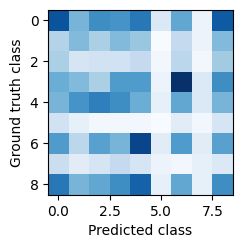

In [ ]:
# Confusion matrix
plt.figure(figsize=(2.4,2.4))
print('Confusion matrix:')
cm2 = confusion_matrix(y_test, y_pred2)
plt.imshow(cm2, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')

## Transfer learning

In [ ]:
# Define the folder name and the file name
file_name = 'model3.h5'

# Define the full file path
file_path = os.path.join(folder_path, file_name)

# Check if the file exists in the specified path
if os.path.exists(file_path):
    model3 = keras.models.load_model('/content/gdrive/MyDrive/History/model3.h5')

    with open(folder_path+"/history3.json", "r") as file:
        loaded_values = json.load(file)

    loss3 = loaded_values[0]
    val_loss3 = loaded_values[1]
    accuracy3 = loaded_values[2]
    val_accuracy3 = loaded_values[3]

else:
    # Base model
    model = keras.applications.MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')

    # Freezing the base model (only for finetuning a pretrained model)
    model.trainable = False

    # Explicit input layer
    inputs = keras.Input(shape=(224, 224, 3))
    x = inputs
    # Image preprocessing for consistency with the pretrained model
    x = keras.applications.mobilenet_v2.preprocess_input(x)
    # Output of the base model
    x = model(x)
    # New intermediate fully-connected layer + ReLU
    x = keras.layers.Dense(1024, activation='relu')(x)
    # New (final) fully-connected layer + SoftMax activation
    outputs = keras.layers.Dense(9, activation='softmax')(x)

    # Specialized model
    net3 = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model for training
    net3.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
                metrics=['accuracy'])

    # Model training
    history3 = net3.fit(train_dataset, epochs=10, validation_data=test_dataset)
    net3.save('/content/gdrive/MyDrive/History/model3.h5')


    # Check if the folder exists, otherwise create it
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    savehistory3 = [history3.history['loss'],
                    history3.history['val_loss'],
                    history3.history['accuracy'],
                    history3.history['val_accuracy']]

    with open(folder_path+"/history3.json", 'w') as file:
        json.dump(savehistory3, file)

    with open(folder_path+"/history3.json", "r") as file:
        loaded_values = json.load(file)

    loss3 = loaded_values[0]
    val_loss3 = loaded_values[1]
    accuracy3 = loaded_values[2]
    val_accuracy3 = loaded_values[3]

    # # Save the dictionary containing the variables to the specified path
    # with open(file_path, 'wb') as f:
    #     pickle.dump(history3, f)

    model3 = keras.models.load_model('/content/gdrive/MyDrive/History/model3.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

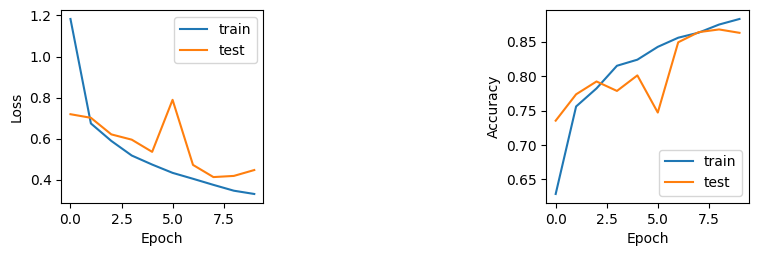

In [ ]:
# Visualization of the learning curves
plt.figure(figsize=(12,2.5))
plt.subplot(1, 4, 1)
# Loss
plt.plot(loss3)
plt.plot(val_loss3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
# Accuracy
plt.subplot(1, 4, 3)
plt.plot(accuracy3)
plt.plot(val_accuracy3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

In [ ]:
score3 = model3.evaluate(test_dataset)
print('Test loss:', score3[0])
print('Test accuracy:', score3[1])

<IPython.core.display.Javascript object>

32/32 [==============================] - 53s 2s/step - loss: 0.4477 - accuracy: 0.8627
Test loss: 0.4476756453514099
Test accuracy: 0.8627451062202454


In [ ]:
# Inference
yc_pred3 = model3.predict(test_dataset)
y_pred3 = np.argmax(yc_pred3, axis=1)

<IPython.core.display.Javascript object>

32/32 [==============================] - 51s 2s/step


In [ ]:
# Classification report
print('Classification report of model 3:')
print(classification_report(y_test, y_pred3))

<IPython.core.display.Javascript object>

Classification report of model 3:
              precision    recall  f1-score   support

           0       0.18      0.21      0.19       175
           1       0.08      0.08      0.08        96
           2       0.04      0.06      0.05        66
           3       0.20      0.18      0.19       154
           4       0.16      0.11      0.13       149
           5       0.09      0.08      0.09        24
           6       0.16      0.15      0.15       150
           7       0.07      0.07      0.07        44
           8       0.15      0.14      0.15       162

    accuracy                           0.14      1020
   macro avg       0.13      0.12      0.12      1020
weighted avg       0.15      0.14      0.14      1020



<IPython.core.display.Javascript object>

Confusion matrix:


Text(0, 0.5, 'Ground truth class')

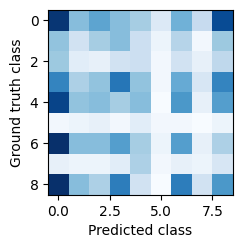

In [ ]:
# Confusion matrix
plt.figure(figsize=(2.4,2.4))
print('Confusion matrix:')
cm3 = confusion_matrix(y_test, y_pred3)
plt.imshow(cm3, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')

## Data augmentation

In [ ]:
# Data loader with (slightly) larger images
train_dataset_256 = keras.preprocessing.image_dataset_from_directory('/content/gdrive/MyDrive/imagesProject/',
                                                            image_size=(256,256),
                                                            batch_size=128,
                                                            label_mode='categorical',
                                                            shuffle=True,
                                                            seed=1)

<IPython.core.display.Javascript object>

Found 5100 files belonging to 9 classes.


In [ ]:
# Define the folder name and the file name
file_name = 'history4.pkl'

# Define the full file path
file_path = os.path.join(folder_path, file_name)

# Check if the file exists in the specified path
if os.path.exists(file_path):
    model4 = keras.models.load_model('/content/gdrive/MyDrive/History/model4.h5')

    # Carica l'oggetto 'variabile' da un file
    with open('/content/gdrive/MyDrive/History/history4.pkl', 'rb') as f:
        load_history4 = pickle.load(f)

else:
    # # Architecture definition (v1)
    inputs = keras.Input((None,None,3))

    x = inputs

    x = keras.layers.RandomCrop(224, 224)(x)
    x = keras.layers.RandomFlip(mode='horizontal')(x)
    x = keras.layers.RandomContrast(0.25)(x)

    x = keras.layers.Conv2D(32, 2, padding='same', activation="relu")(x)
    x = keras.layers.MaxPooling2D(2, strides=3, padding='same')(x)

    x = keras.layers.Conv2D(64, 2, padding='same', activation="relu")(x)
    x = keras.layers.GlobalMaxPooling2D()(x)

    outputs = keras.layers.Dense(9, activation='softmax')(x)
    net4 = keras.Model(inputs, outputs)

    # Compile the model for training
    net4.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
                metrics=['accuracy'])

    # Model training (v2)
    history4 = net4.fit(train_dataset_256,
            epochs=40,
            validation_data=test_dataset)

    net4.save('/content/gdrive/MyDrive/History/model4.h5')

    # Check if the folder exists, otherwise create it
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Save the dictionary containing the variables to the specified path
    with open(file_path, 'wb') as f:
        pickle.dump(history4, f)

    model4 = keras.models.load_model('/content/gdrive/MyDrive/History/model4.h5')

    # Carica l'oggetto 'variabile' da un file
    with open('/content/gdrive/MyDrive/History/history4.pkl', 'rb') as f:
        load_history4 = pickle.load(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

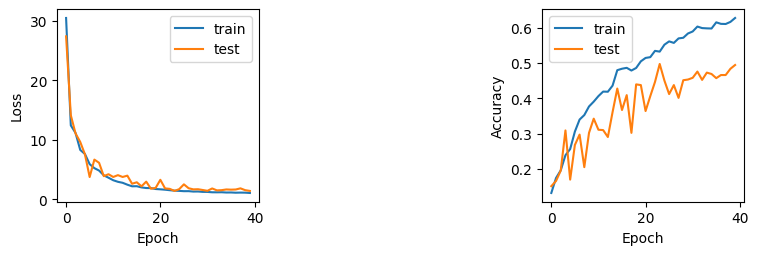

In [ ]:
# Visualization of the learning curves
plt.figure(figsize=(12,2.5))
plt.subplot(1, 4, 1)
# Loss
plt.plot(load_history4.history['loss'])
plt.plot(load_history4.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
# Accuracy
plt.subplot(1, 4, 3)
plt.plot(load_history4.history['accuracy'])
plt.plot(load_history4.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

In [ ]:
score4 = model4.evaluate(test_dataset)
print('Test loss:', score4[0])
print('Test accuracy:', score4[1])

<IPython.core.display.Javascript object>

32/32 [==============================] - 23s 655ms/step - loss: 1.4324 - accuracy: 0.4941
Test loss: 1.4324290752410889
Test accuracy: 0.4941176474094391


In [ ]:
# Inference
yc_pred4 = model4.predict(test_dataset)
y_pred4 = np.argmax(yc_pred4, axis=1)

<IPython.core.display.Javascript object>

32/32 [==============================] - 21s 611ms/step


In [ ]:
# Classification report
print('Classification report of model 4:')
print(classification_report(y_test, y_pred4))

<IPython.core.display.Javascript object>

Classification report of model 4:
              precision    recall  f1-score   support

           0       0.18      0.14      0.16       175
           1       0.08      0.17      0.11        96
           2       0.06      0.03      0.04        66
           3       0.18      0.19      0.19       154
           4       0.16      0.26      0.20       149
           5       0.00      0.00      0.00        24
           6       0.12      0.11      0.11       150
           7       0.08      0.02      0.04        44
           8       0.12      0.06      0.08       162

    accuracy                           0.14      1020
   macro avg       0.11      0.11      0.10      1020
weighted avg       0.13      0.14      0.13      1020



<IPython.core.display.Javascript object>

Confusion matrix:


Text(0, 0.5, 'Ground truth class')

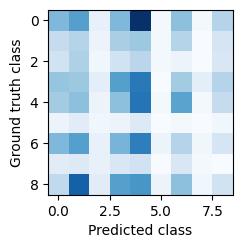

In [ ]:
# Confusion matrix
plt.figure(figsize=(2.4,2.4))
print('Confusion matrix:')
cm4 = confusion_matrix(y_test, y_pred4)
plt.imshow(cm4, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')